# Biblioteki

In [1]:
import os
import cv2
import random
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from skimage.feature import graycoprops
from skimage.feature.texture import graycomatrix
from sklearn.svm import SVC

# Wyrównanie liczby obrazów dla wszystkich klas

In [2]:
def balance_classes(data_dir):
    class_folders = [os.path.join(data_dir, folder) for folder in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, folder))]
    class_counts = {folder: len(os.listdir(folder)) for folder in class_folders}
    print(class_counts)
    
    min_count = min(class_counts.values())
    print(f"Balancing to {min_count} images per class in {data_dir}")
    
    for folder, count in class_counts.items():
        if count > min_count:
            files = os.listdir(folder)
            files_to_remove = random.sample(files, count - min_count)
            for file in files_to_remove:
                os.remove(os.path.join(folder, file))
                print(f"Removed {file} from {folder}")

training_path = 'data/Training'
test_path = 'data/Test'

balance_classes(training_path)
balance_classes(test_path)

{'data/Training\\Apple Red 2': 426, 'data/Training\\Apricot 1': 426, 'data/Training\\Avocado 1': 426, 'data/Training\\Avocado ripe 1': 426, 'data/Training\\Banana 1': 426, 'data/Training\\Blueberry 1': 426, 'data/Training\\Cactus fruit 1': 426, 'data/Training\\Cantaloupe 1': 426, 'data/Training\\Cauliflower 1': 426, 'data/Training\\Cherry 1': 426, 'data/Training\\Clementine 1': 426, 'data/Training\\Cocos 1': 426, 'data/Training\\Corn 1': 426, 'data/Training\\Dates 1': 426, 'data/Training\\Eggplant 1': 426, 'data/Training\\Fig 1': 426, 'data/Training\\Grape White 1': 426, 'data/Training\\Kiwi 1': 426, 'data/Training\\Lemon 1': 426, 'data/Training\\Lemon Meyer 1': 426, 'data/Training\\Limes 1': 426, 'data/Training\\Lychee 1': 426, 'data/Training\\Mandarine 1': 426, 'data/Training\\Mango 1': 426, 'data/Training\\Mango Red 1': 426, 'data/Training\\Maracuja 1': 426, 'data/Training\\Mulberry 1': 426, 'data/Training\\Nectarine 1': 426, 'data/Training\\Onion Red 1': 426, 'data/Training\\Onion 

In [3]:
data_dir = 'data/Training'
classes = os.listdir(data_dir)
print(f'Liczba klas: {len(classes)}')
print('Klasy:', classes)

Liczba klas: 50
Klasy: ['Apple Red 2', 'Apricot 1', 'Avocado 1', 'Avocado ripe 1', 'Banana 1', 'Blueberry 1', 'Cactus fruit 1', 'Cantaloupe 1', 'Cauliflower 1', 'Cherry 1', 'Clementine 1', 'Cocos 1', 'Corn 1', 'Dates 1', 'Eggplant 1', 'Fig 1', 'Grape White 1', 'Kiwi 1', 'Lemon 1', 'Lemon Meyer 1', 'Limes 1', 'Lychee 1', 'Mandarine 1', 'Mango 1', 'Mango Red 1', 'Maracuja 1', 'Mulberry 1', 'Nectarine 1', 'Onion Red 1', 'Onion White 1', 'Orange 1', 'Papaya 1', 'Passion Fruit 1', 'Peach 1', 'Pear 1', 'Pepino 1', 'Pepper Red 1', 'Pineapple 1', 'Pineapple Mini 1', 'Pitahaya Red 1', 'Plum 1', 'Pomegranate 1', 'Pomelo Sweetie 1', 'Raspberry 1', 'Redcurrant 1', 'Strawberry 1', 'Tamarillo 1', 'Tangelo 1', 'Tomato 1', 'Watermelon 1']


# Ekstrakcja cech - funkcja

In [4]:
def extract_features(image):
    import cv2
    import numpy as np
    from skimage.feature import graycomatrix, graycoprops
    
    # Resize dla pewnosci
    image = cv2.resize(image, (100, 100))
    
    # HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    hist_features = hist.flatten()
    
    # grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # GLCM
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    ASM = graycoprops(glcm, 'ASM')[0, 0]
    texture_features = [contrast, dissimilarity, homogeneity, energy, correlation, ASM]
    
    # Canny
    median_val = np.median(gray)
    lower_thresh = int(max(0, (1.0 - 0.33) * median_val))
    upper_thresh = int(min(255, (1.0 + 0.33) * median_val))
    edges = cv2.Canny(gray, threshold1=lower_thresh, threshold2=upper_thresh)
    edge_density = np.sum(edges) / (edges.shape[0] * edges.shape[1])

    # Identyfikacja ksztaltow
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    shape_features = []
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        perimeter = cv2.arcLength(largest_contour, True)
        approx = cv2.approxPolyDP(largest_contour, 0.04 * perimeter, True)
        if len(approx) == 3:
            shape_features = [1, 0, 0, 0]  # trójkąt
        elif len(approx) == 4:
            shape_features = [0, 1, 0, 0]  # czwotokąt
        elif len(approx) > 4:
            shape_features = [0, 0, 1, 0]  # koło/owal
        else:
            shape_features = [0, 0, 0, 1]  # nieznany kształt
    else:
        shape_features = [0, 0, 0, 1]  # nieznany kształt - brak konturów

    # RGB
    chans = cv2.split(image)
    hist_rgb = []
    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        cv2.normalize(hist, hist)
        hist_rgb.extend(hist.flatten())

    # Merge
    features = np.hstack([hist_features, texture_features, edge_density, shape_features, hist_rgb])
    
    return features


# Ekstrakcja cech - train

In [5]:
X_train = []
y_train = []

for label in classes:
    path = os.path.join(data_dir, label)
    for img_name in os.listdir(path):
        print(f'processing: {img_name}')
        img_path = os.path.join(path, img_name)
        image = cv2.imread(img_path)
        features = extract_features(image)
        X_train.append(features)
        y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

processing: 0_100.jpg
processing: 100_100.jpg
processing: 101_100.jpg
processing: 102_100.jpg
processing: 103_100.jpg
processing: 104_100.jpg
processing: 105_100.jpg
processing: 106_100.jpg
processing: 107_100.jpg
processing: 108_100.jpg
processing: 109_100.jpg
processing: 10_100.jpg
processing: 110_100.jpg
processing: 111_100.jpg
processing: 112_100.jpg
processing: 114_100.jpg
processing: 115_100.jpg
processing: 116_100.jpg
processing: 117_100.jpg
processing: 118_100.jpg
processing: 119_100.jpg
processing: 120_100.jpg
processing: 121_100.jpg
processing: 122_100.jpg
processing: 123_100.jpg
processing: 124_100.jpg
processing: 126_100.jpg
processing: 127_100.jpg
processing: 128_100.jpg
processing: 129_100.jpg
processing: 12_100.jpg
processing: 130_100.jpg
processing: 131_100.jpg
processing: 132_100.jpg
processing: 133_100.jpg
processing: 134_100.jpg
processing: 135_100.jpg
processing: 136_100.jpg
processing: 137_100.jpg
processing: 138_100.jpg
processing: 139_100.jpg
processing: 13_100.j

# Ekstrakcja cech - test

In [6]:
data_dir_test = 'data/Test'
X_test = []
y_test = []
image_paths_test = []

for label in classes:
    path = os.path.join(data_dir_test, label)
    for img_name in os.listdir(path):
        print(f'processing: {img_name}')
        img_path = os.path.join(path, img_name)
        image = cv2.imread(img_path)
        features = extract_features(image)
        X_test.append(features)
        y_test.append(label)
        image_paths_test.append(img_path)

X_test = np.array(X_test)
y_test = np.array(y_test)


processing: 321_100.jpg
processing: 322_100.jpg
processing: 323_100.jpg
processing: 324_100.jpg
processing: 325_100.jpg
processing: 326_100.jpg
processing: 327_100.jpg
processing: 32_100.jpg
processing: 33_100.jpg
processing: 34_100.jpg
processing: 35_100.jpg
processing: 36_100.jpg
processing: 37_100.jpg
processing: 38_100.jpg
processing: 39_100.jpg
processing: 3_100.jpg
processing: 40_100.jpg
processing: 41_100.jpg
processing: 42_100.jpg
processing: 43_100.jpg
processing: 44_100.jpg
processing: 45_100.jpg
processing: 46_100.jpg
processing: 47_100.jpg
processing: 48_100.jpg
processing: 49_100.jpg
processing: 4_100.jpg
processing: 50_100.jpg
processing: 51_100.jpg
processing: 52_100.jpg
processing: 53_100.jpg
processing: 54_100.jpg
processing: 55_100.jpg
processing: 56_100.jpg
processing: 57_100.jpg
processing: 58_100.jpg
processing: 59_100.jpg
processing: 5_100.jpg
processing: 60_100.jpg
processing: 61_100.jpg
processing: 62_100.jpg
processing: 63_100.jpg
processing: 64_100.jpg
process

# K-NN - szukanie najlepszego K

Best k: 1 with accuracy: 0.5815
Accuracy K-NN: 0.5815492957746479
Classification Report K-NN:
                  precision    recall  f1-score   support

     Apple Red 2       0.61      0.73      0.66       142
       Apricot 1       0.87      0.63      0.73       142
       Avocado 1       0.49      0.45      0.47       142
  Avocado ripe 1       0.58      0.58      0.58       142
        Banana 1       0.69      0.66      0.68       142
     Blueberry 1       0.62      0.62      0.62       142
  Cactus fruit 1       0.35      0.41      0.37       142
    Cantaloupe 1       1.00      1.00      1.00       142
   Cauliflower 1       0.42      0.53      0.47       142
        Cherry 1       0.71      0.86      0.78       142
    Clementine 1       0.91      0.74      0.81       142
         Cocos 1       0.67      0.40      0.50       142
          Corn 1       0.27      0.36      0.31       142
         Dates 1       0.58      0.70      0.64       142
      Eggplant 1       0.78      0.

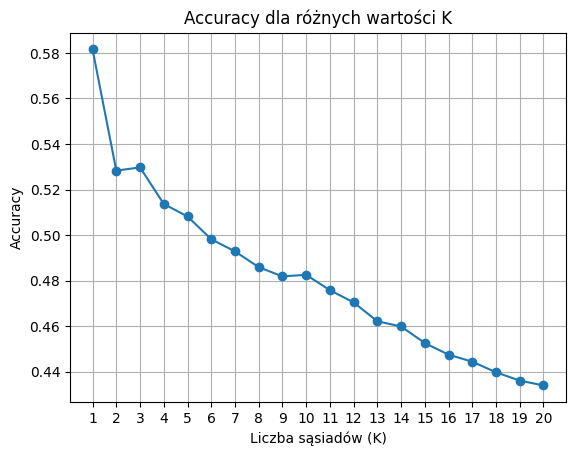

In [7]:
def find_best_k(X_train, y_train, X_test, y_test, max_k):
    best_k = 1
    best_accuracy = 0
    accuracy_per_k = []

    for k in range(1, max_k + 1):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred_knn = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred_knn)
        accuracy_per_k.append((k, accuracy))
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_k = k

    return best_k, best_accuracy, accuracy_per_k

max_k = 20
best_k, best_accuracy, accuracy_per_k = find_best_k(X_train, y_train, X_test, y_test, max_k)
print(f'Best k: {best_k} with accuracy: {best_accuracy:.4f}')

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print('Accuracy K-NN:', accuracy_score(y_test, y_pred_knn))
print('Classification Report K-NN:')
print(classification_report(y_test, y_pred_knn))

ks, accuracies = zip(*accuracy_per_k)
plt.plot(ks, accuracies, marker='o')
plt.title('Accuracy dla różnych wartości K')
plt.xlabel('Liczba sąsiadów (K)')
plt.ylabel('Accuracy')
plt.xticks(range(1, max_k + 1))
plt.grid()
plt.show()

# K-NN

In [8]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train_encoded)

y_pred_knn_encoded = knn.predict(X_test)
y_pred_knn = label_encoder.inverse_transform(y_pred_knn_encoded)

print('Accuracy K-NN:', accuracy_score(y_test, y_pred_knn))
print('Classification Report K-NN:')
print(classification_report(y_test, y_pred_knn))

Accuracy K-NN: 0.5815492957746479
Classification Report K-NN:
                  precision    recall  f1-score   support

     Apple Red 2       0.61      0.73      0.66       142
       Apricot 1       0.87      0.63      0.73       142
       Avocado 1       0.49      0.45      0.47       142
  Avocado ripe 1       0.58      0.58      0.58       142
        Banana 1       0.69      0.66      0.68       142
     Blueberry 1       0.62      0.62      0.62       142
  Cactus fruit 1       0.35      0.41      0.37       142
    Cantaloupe 1       1.00      1.00      1.00       142
   Cauliflower 1       0.42      0.53      0.47       142
        Cherry 1       0.71      0.86      0.78       142
    Clementine 1       0.91      0.74      0.81       142
         Cocos 1       0.67      0.40      0.50       142
          Corn 1       0.27      0.36      0.31       142
         Dates 1       0.58      0.70      0.64       142
      Eggplant 1       0.78      0.37      0.50       142
         

# K-NN Manhattan

In [9]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

knn_manhattan = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
knn_manhattan.fit(X_train, y_train_encoded)
y_pred_knn_manhattan_encoded = knn_manhattan.predict(X_test)

y_pred_knn_manhattan = label_encoder.inverse_transform(y_pred_knn_manhattan_encoded)

print('Accuracy K-NN (Manhattan, n_neighbors=1):', accuracy_score(y_test, y_pred_knn_manhattan))
print('Classification Report K-NN (Manhattan, n_neighbors=1):')
print(classification_report(y_test, y_pred_knn_manhattan))

Accuracy K-NN (Manhattan, n_neighbors=1): 0.927887323943662
Classification Report K-NN (Manhattan, n_neighbors=1):
                  precision    recall  f1-score   support

     Apple Red 2       0.99      0.90      0.94       142
       Apricot 1       1.00      0.98      0.99       142
       Avocado 1       0.95      0.97      0.96       142
  Avocado ripe 1       0.98      0.88      0.93       142
        Banana 1       0.91      0.94      0.92       142
     Blueberry 1       0.95      1.00      0.97       142
  Cactus fruit 1       0.70      0.80      0.75       142
    Cantaloupe 1       1.00      1.00      1.00       142
   Cauliflower 1       0.93      0.96      0.94       142
        Cherry 1       0.99      1.00      0.99       142
    Clementine 1       1.00      0.95      0.97       142
         Cocos 1       1.00      0.86      0.92       142
          Corn 1       0.68      0.63      0.65       142
         Dates 1       0.77      0.93      0.84       142
      Eggplant

# SVM

In [10]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

print('Accuracy SVM:', accuracy_score(y_test, y_pred_svm))
print('Classification Report SVM:')
print(classification_report(y_test, y_pred_svm))

Accuracy SVM: 0.9519718309859155
Classification Report SVM:
                  precision    recall  f1-score   support

     Apple Red 2       1.00      0.92      0.96       142
       Apricot 1       0.99      1.00      1.00       142
       Avocado 1       0.94      1.00      0.97       142
  Avocado ripe 1       1.00      0.99      0.99       142
        Banana 1       0.74      0.83      0.78       142
     Blueberry 1       1.00      0.99      1.00       142
  Cactus fruit 1       0.53      0.72      0.61       142
    Cantaloupe 1       1.00      1.00      1.00       142
   Cauliflower 1       1.00      1.00      1.00       142
        Cherry 1       1.00      1.00      1.00       142
    Clementine 1       1.00      1.00      1.00       142
         Cocos 1       1.00      0.87      0.93       142
          Corn 1       0.78      0.58      0.67       142
         Dates 1       0.87      1.00      0.93       142
      Eggplant 1       1.00      0.54      0.70       142
           

# Macierz pomyłek - K-NN

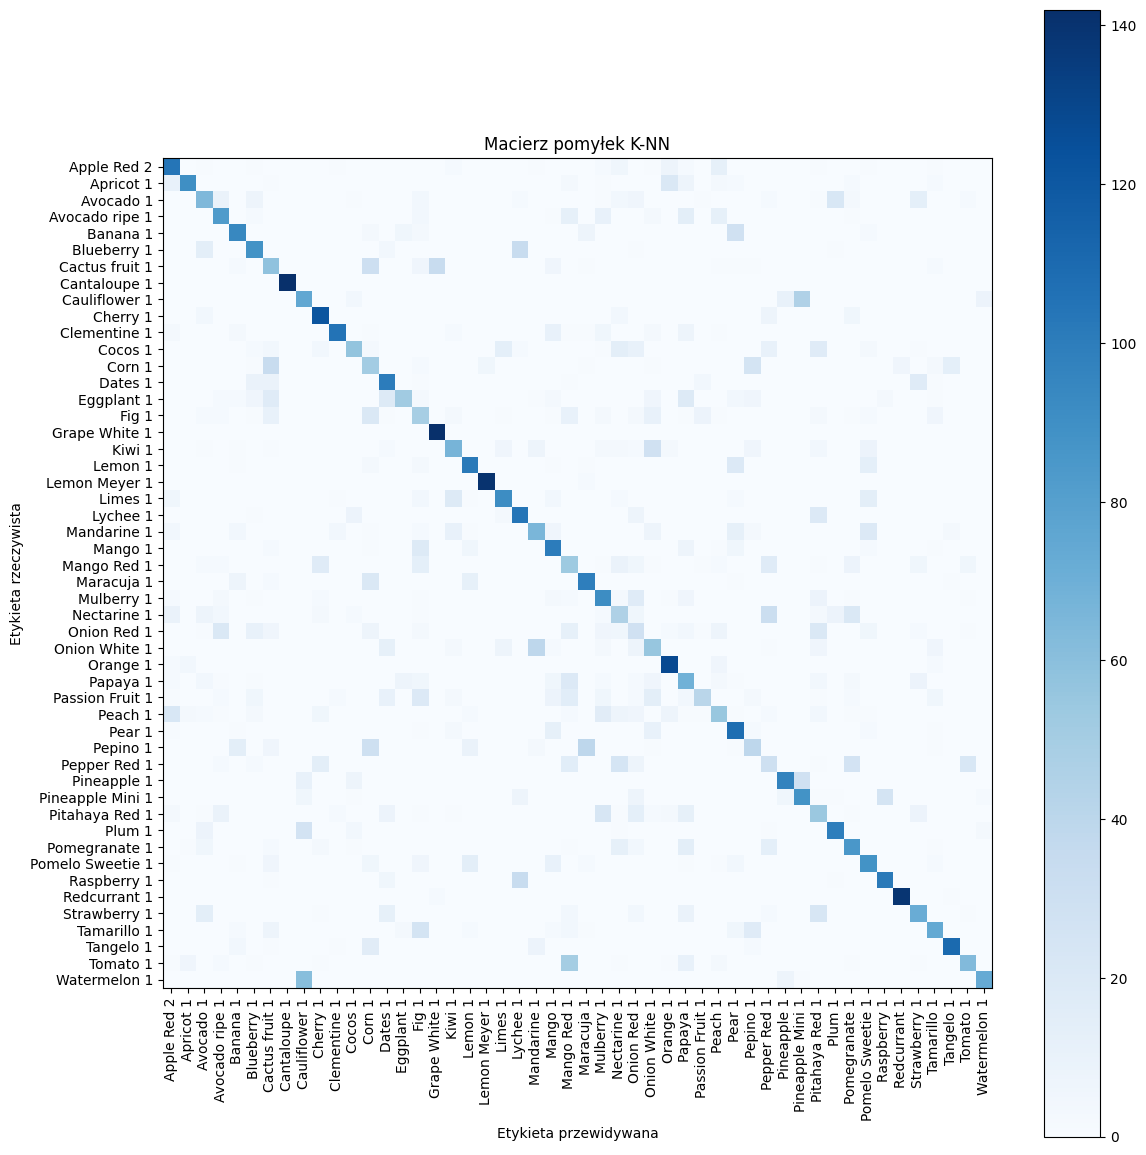

In [11]:
cm = confusion_matrix(y_test, y_pred_knn, labels=classes)
plt.figure(figsize=(12,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Macierz pomyłek K-NN')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('Etykieta rzeczywista')
plt.xlabel('Etykieta przewidywana')
plt.show()

# Macierz pomyłek - K-NN - Manhattan

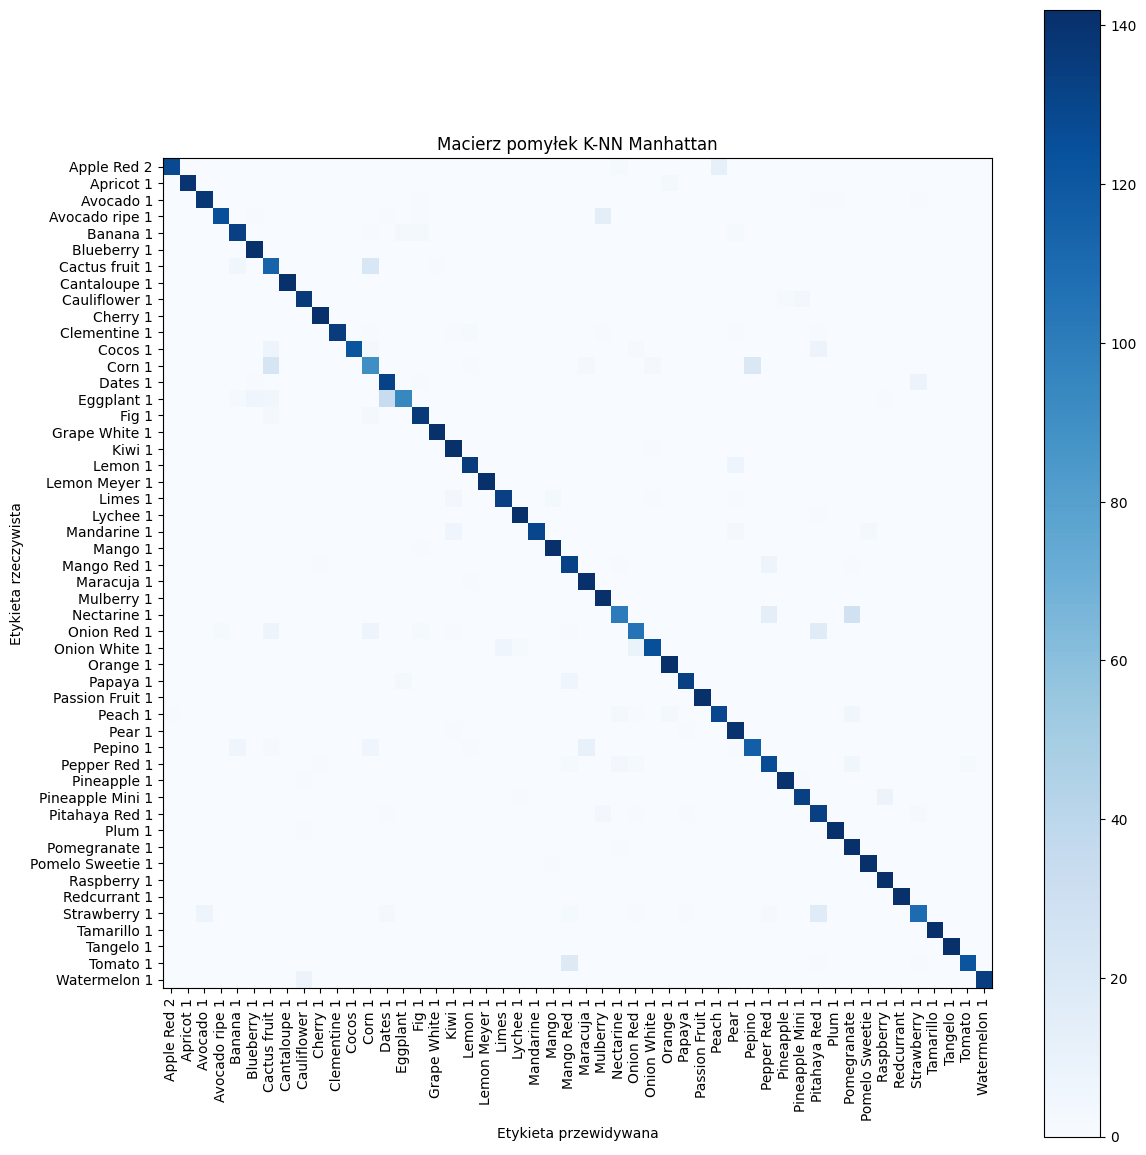

In [12]:
cm = confusion_matrix(y_test, y_pred_knn_manhattan, labels=classes)
plt.figure(figsize=(12,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Macierz pomyłek K-NN Manhattan')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('Etykieta rzeczywista')
plt.xlabel('Etykieta przewidywana')
plt.show()

# Macierz pomyłek - SVM

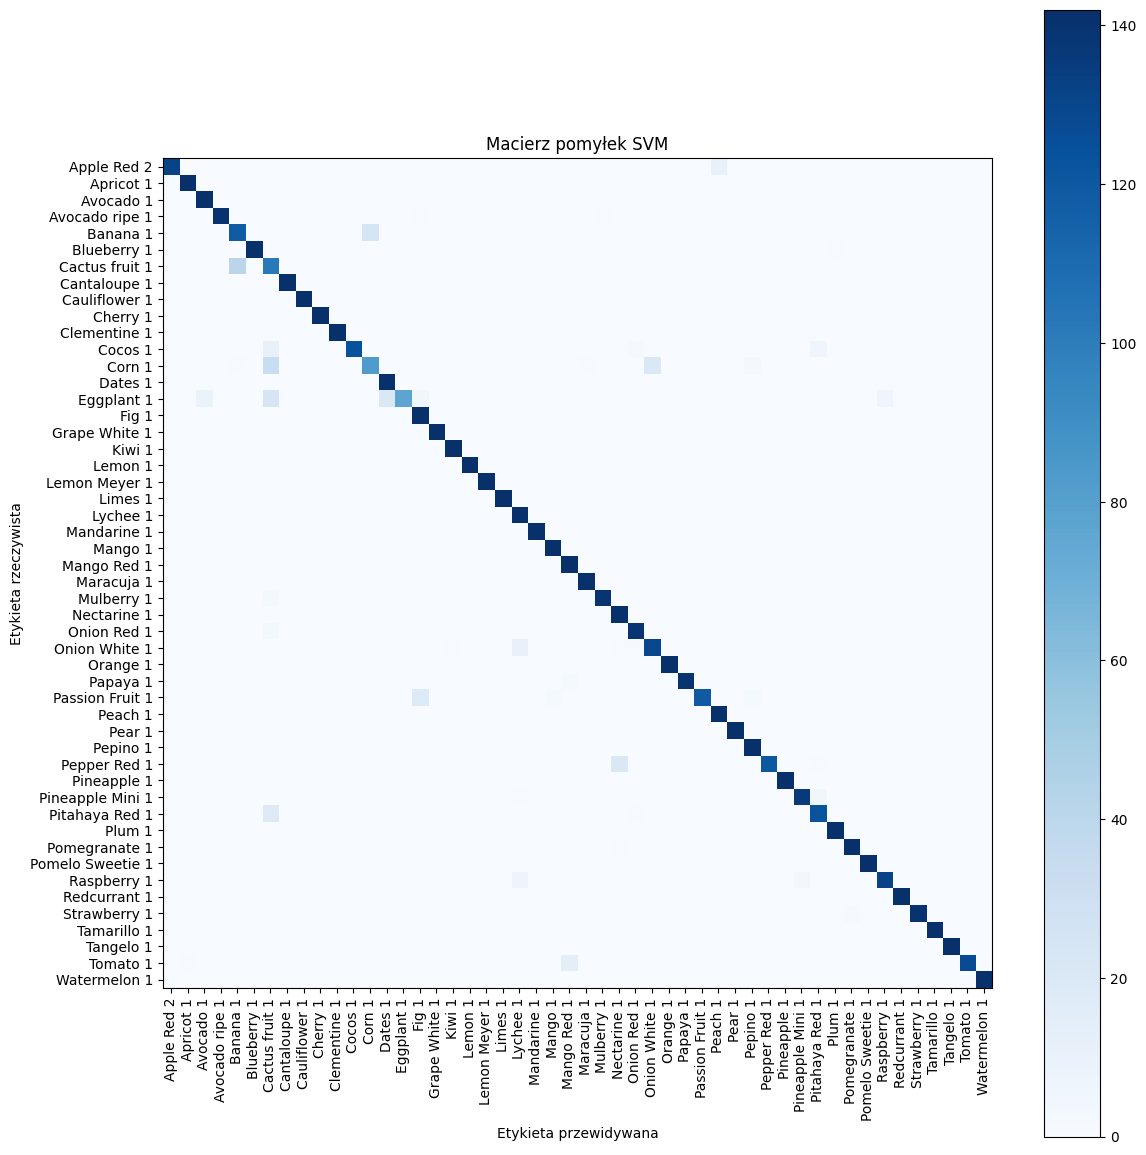

In [13]:
cm = confusion_matrix(y_test, y_pred_svm, labels=classes)
plt.figure(figsize=(12,12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Macierz pomyłek SVM')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)
plt.tight_layout()
plt.ylabel('Etykieta rzeczywista')
plt.xlabel('Etykieta przewidywana')
plt.show()

# --------- Przykłady ---------

# Histogram HSV

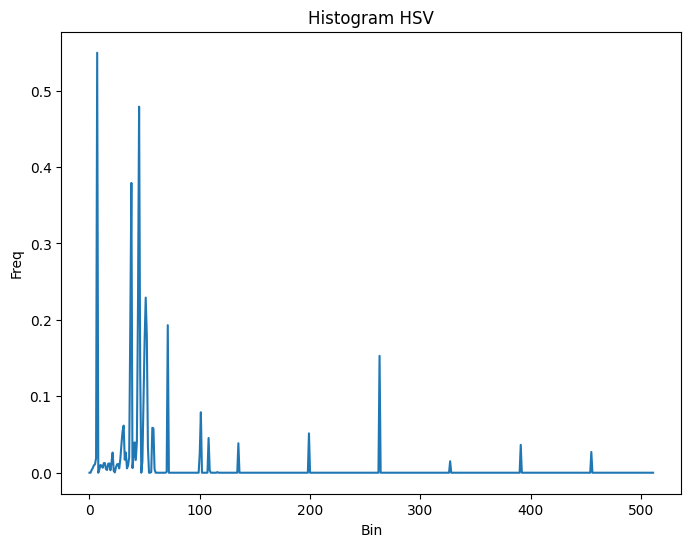

In [14]:
def plot_histogram(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (100, 100))
    
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [8, 8, 8], [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    
    plt.figure(figsize=(8, 6))
    plt.title("Histogram HSV")
    plt.xlabel("Bin")
    plt.ylabel("Freq")
    plt.plot(hist.flatten())
    plt.show()

plot_histogram('data/Training/Apple Red 2/0_100.jpg')

# Histogram GLCM

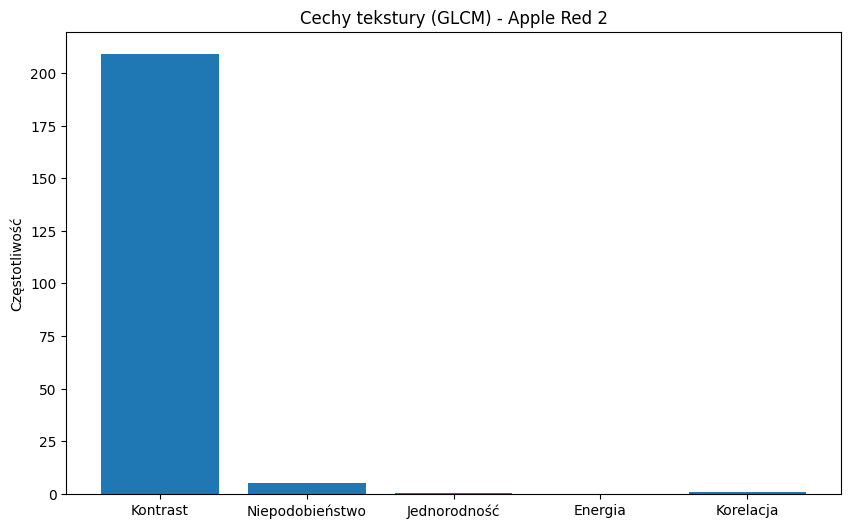

In [15]:
def plot_glcm_features(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (100, 100))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256,
                        symmetric=True, normed=True)
    
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    
    features = {
        'Kontrast': contrast,
        'Niepodobieństwo': dissimilarity,
        'Jednorodność': homogeneity,
        'Energia': energy,
        'Korelacja': correlation
    }
    
    plt.figure(figsize=(10, 6))
    plt.bar(features.keys(), features.values())
    plt.title("Cechy tekstury (GLCM) - Apple Red 2")
    plt.ylabel("Częstotliwość")
    plt.show()

plot_glcm_features('data/Training/Apple Red 2/0_100.jpg')

# Histogram RGB

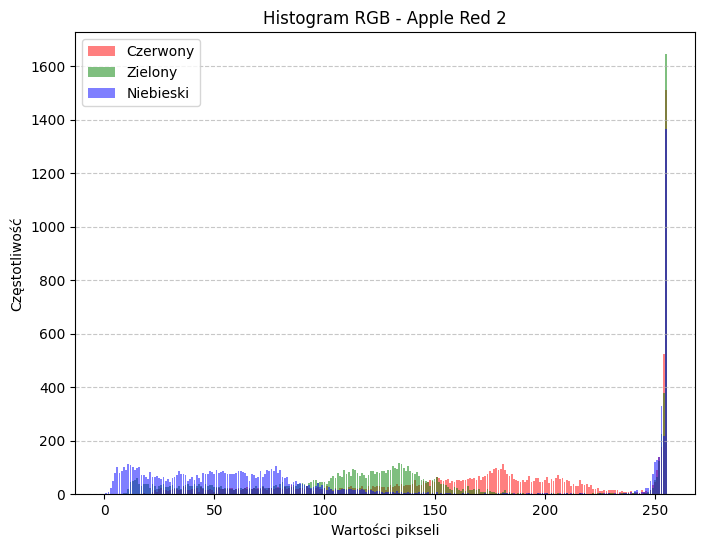

In [16]:
image = cv2.imread('data/Training/Apple Red 2/0_100.jpg')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

colors = ('r', 'g', 'b')
labels = ['Czerwony', 'Zielony', 'Niebieski']
plt.figure(figsize=(8, 6))

for i, color in enumerate(colors):
    hist = cv2.calcHist([image_rgb], [i], None, [256], [0, 256])
    plt.bar(range(256), hist.flatten(), color=color, alpha=0.5, label=labels[i])

plt.title("Histogram RGB - Apple Red 2")
plt.xlabel("Wartości pikseli")
plt.ylabel("Częstotliwość")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Canny

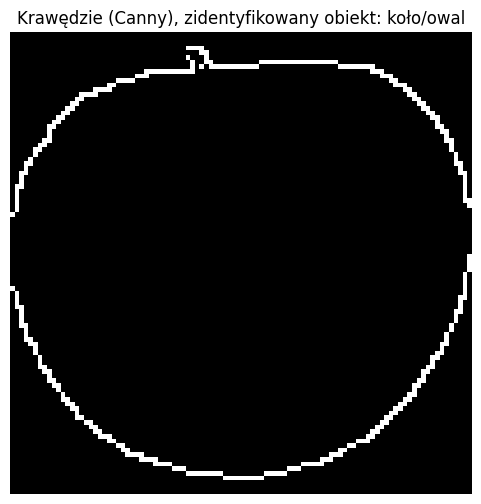

In [17]:
def plot_edges(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (100, 100))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    median_val = np.median(gray)
    lower_thresh = int(max(0, (1.0 - 0.33) * median_val))
    upper_thresh = int(min(255, (1.0 + 0.33) * median_val))
    edges = cv2.Canny(gray, threshold1=lower_thresh, threshold2=upper_thresh)
    
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        perimeter = cv2.arcLength(largest_contour, True)
        approx = cv2.approxPolyDP(largest_contour, 0.04 * perimeter, True)
        if len(approx) == 3:
            object = "trójkąt"
        elif len(approx) == 4:
            object = "czworokąt"
        elif len(approx) > 4:
            object = "koło/owal"
        else:
            object = "nieznany kształt"
    else:
        object = "nieznany kształt"
    
    plt.figure(figsize=(6, 6))
    plt.title(f"Krawędzie (Canny), zidentyfikowany obiekt: {object}")
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    plt.show()

plot_edges('data/Training/Apple Red 2/0_100.jpg')

# Najczęściej źle klasyfikowane obiekty - SVM

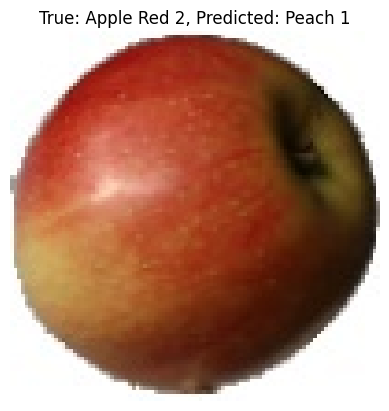

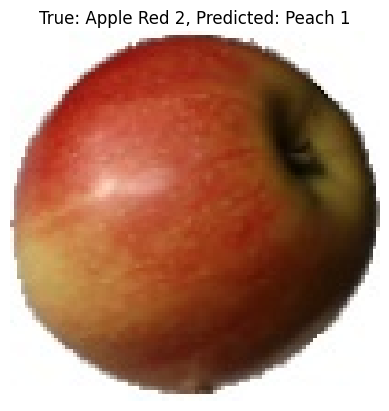

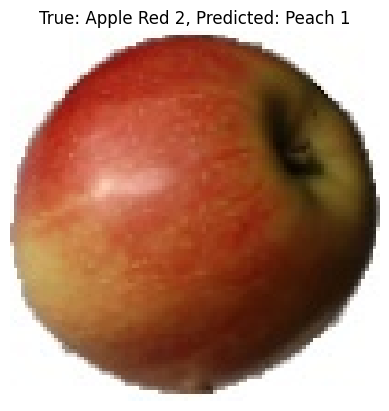

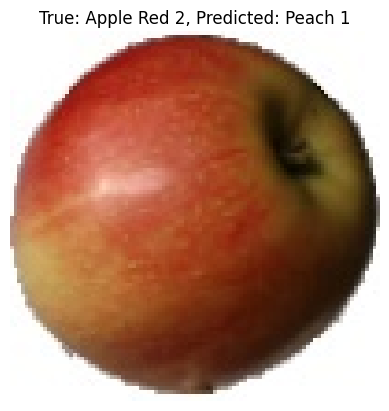

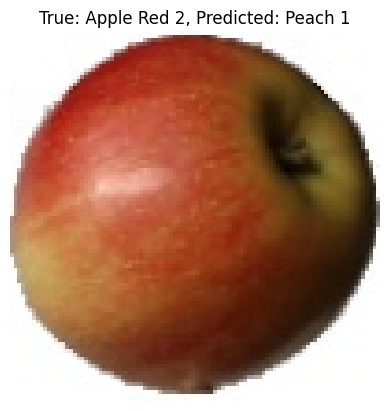

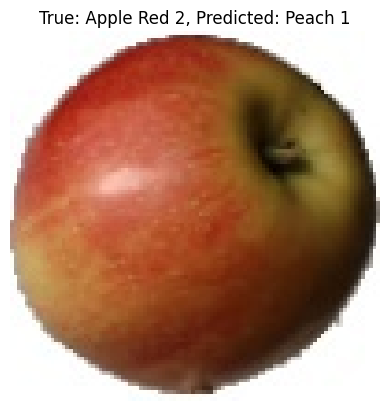

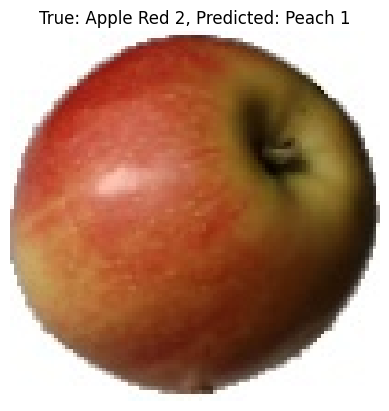

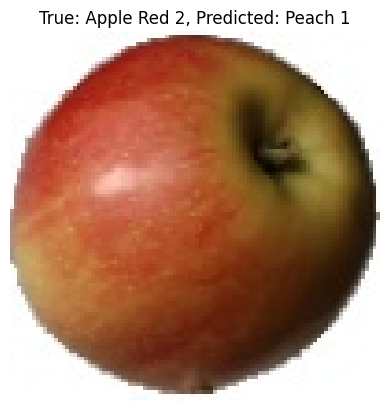

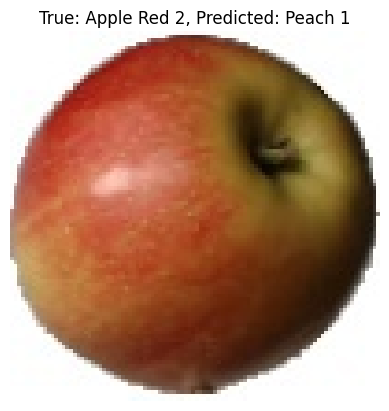

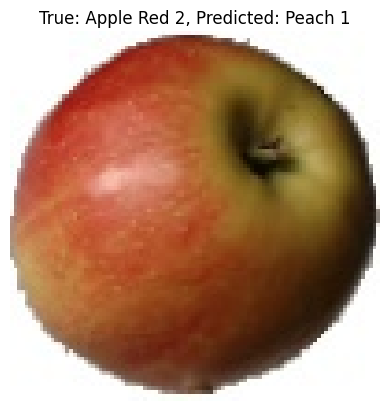

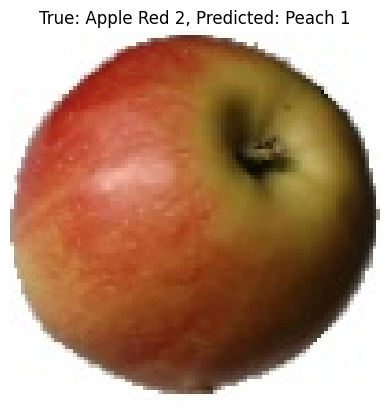

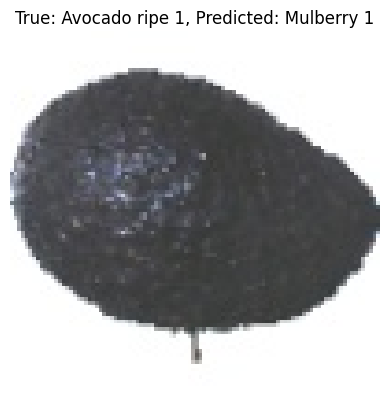

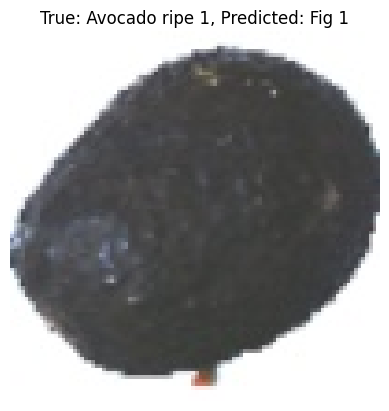

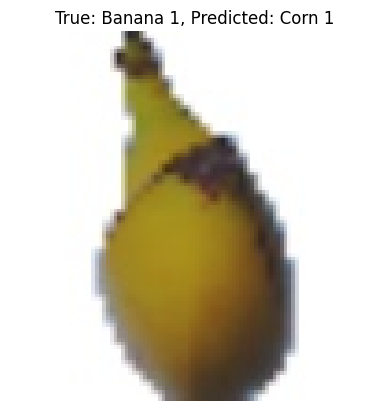

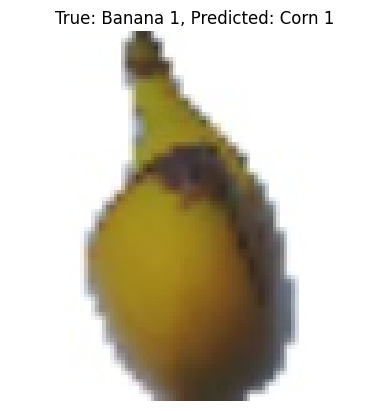

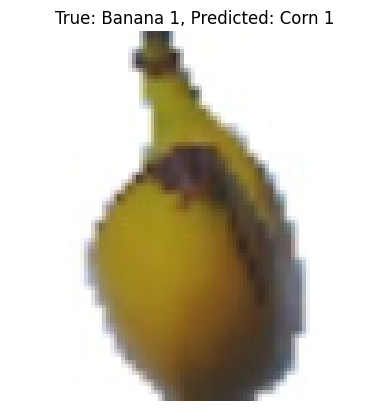

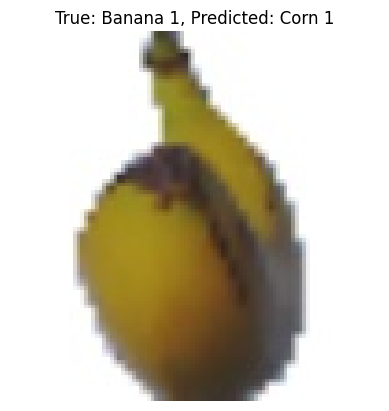

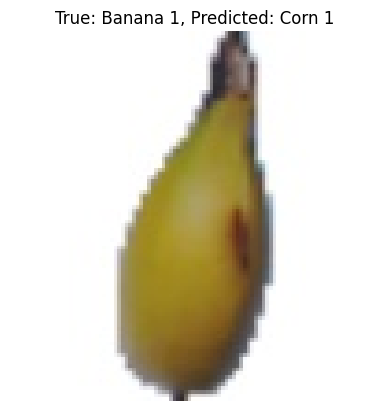

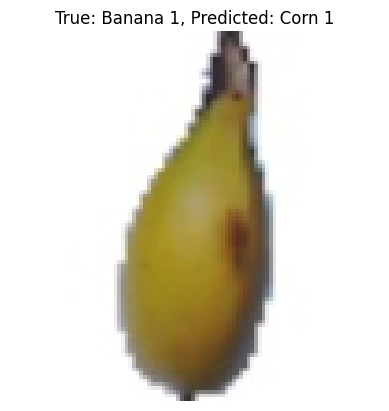

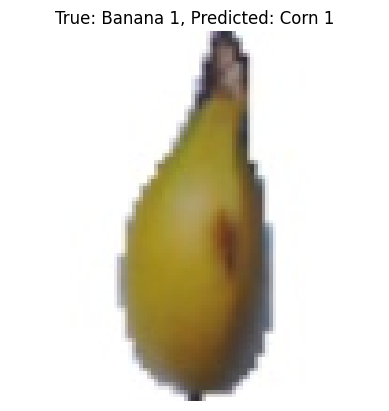

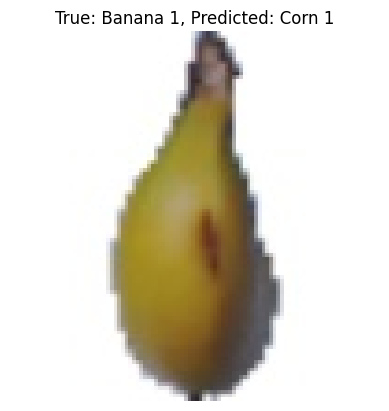

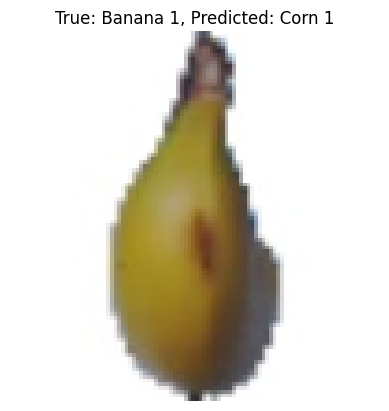

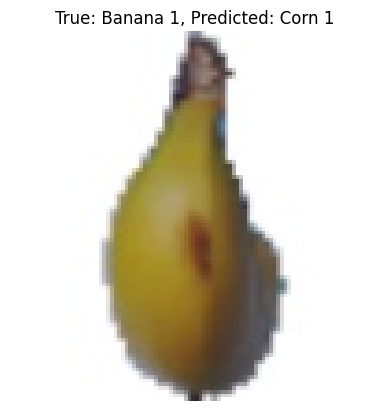

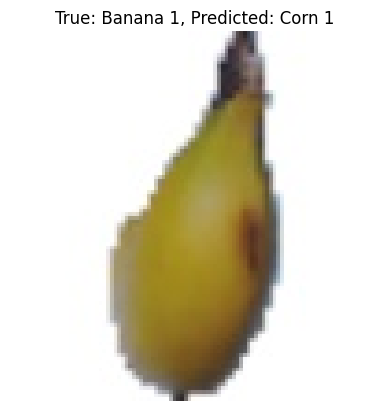

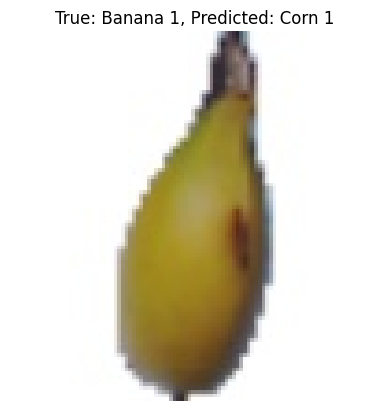

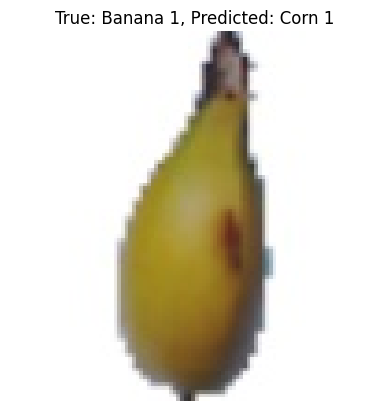

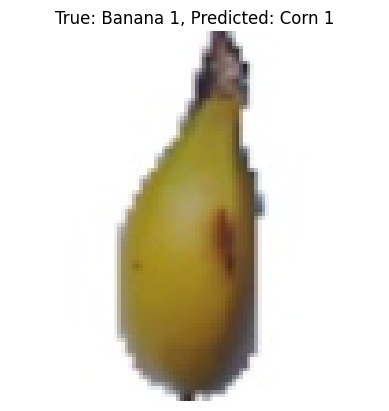

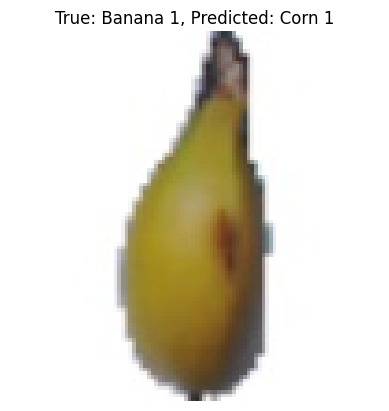

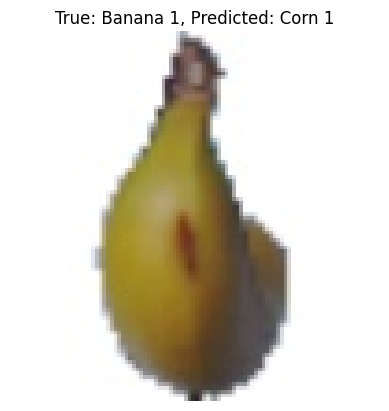

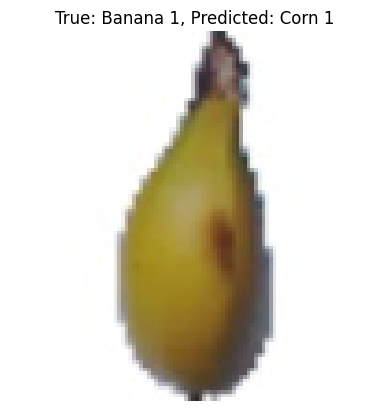

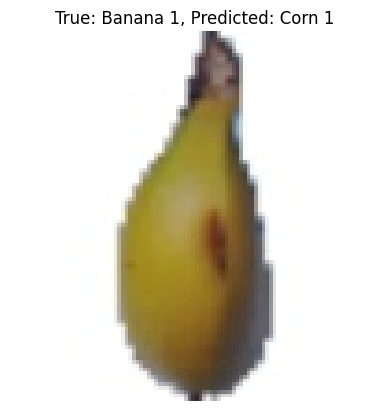

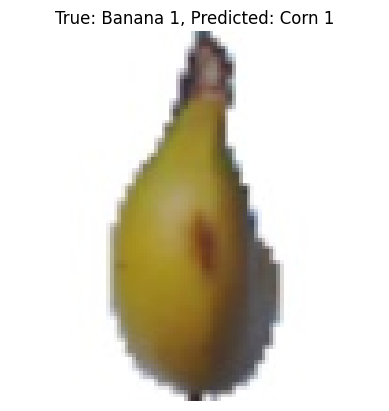

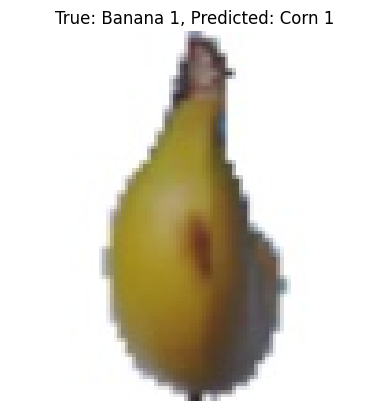

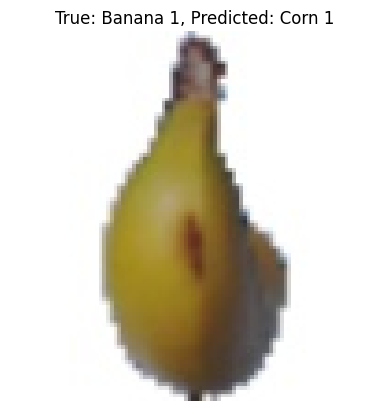

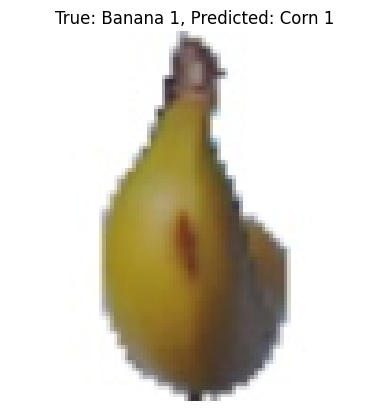

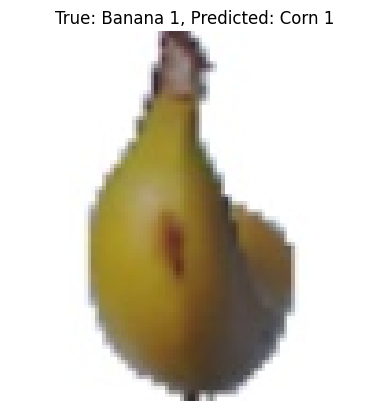

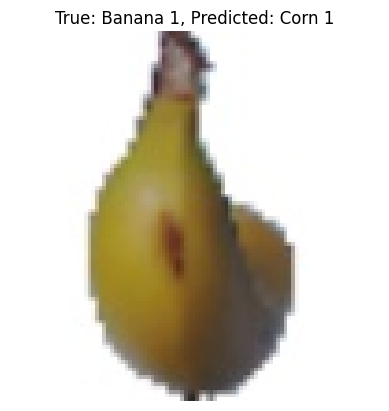

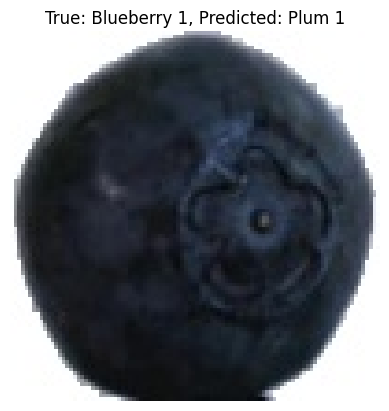

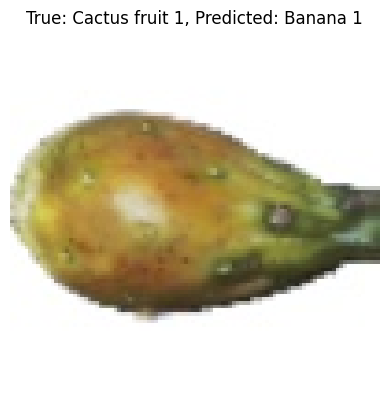

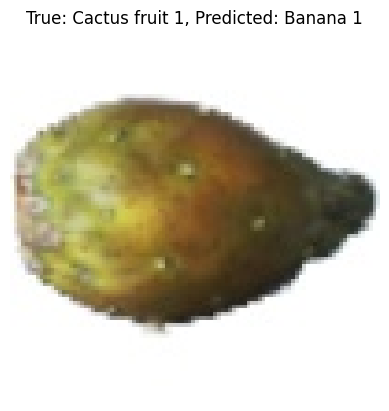

In [18]:
misclassified_indices = np.where(y_test != y_pred_svm)[0]

for i in misclassified_indices[:40]:
    img_path = image_paths_test[i]
    original_image = cv2.imread(img_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(original_image)
    plt.title(f"True: {y_test[i]}, Predicted: {y_pred_svm[i]}")
    plt.axis('off')
    plt.show()

# Live demo

In [19]:
def live_demo(image_path):
    image = cv2.imread(image_path)
    features = extract_features(image)
    features = np.array(features).reshape(1, -1)
    predicted_class = svm_model.predict(features)

    return predicted_class

In [20]:
path = 'data/Test/Pear 1/36_100.jpg'
predicted_class = live_demo(path)
print(f"Przewidziana klasa dla obrazu {path}': {predicted_class[0]}")

Przewidziana klasa dla obrazu data/Test/Pear 1/36_100.jpg': Pear 1


In [21]:
path = 'data/Test/Orange 1/4_100.jpg'
predicted_class = live_demo(path)
print(f"Przewidziana klasa dla obrazu {path}': {predicted_class[0]}")

Przewidziana klasa dla obrazu data/Test/Orange 1/4_100.jpg': Orange 1


In [22]:
path = 'data/Test/Watermelon 1/125_100.jpg'
predicted_class = live_demo(path)
print(f"Przewidziana klasa dla obrazu {path}': {predicted_class[0]}")

Przewidziana klasa dla obrazu data/Test/Watermelon 1/125_100.jpg': Watermelon 1
